In [1]:
import os
import yaml
import sys
import datetime
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from einops import rearrange, repeat

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
# mushroom
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [5]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [6]:
date_str = re.sub(r' |:|\.', r'_', str(datetime.datetime.today()))
date_str

'2024-01-25_18_03_24_580462'

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/htan_talk'
mushroom_dir = os.path.join(run_dir, f'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps = [fp for fp in config_fps if 'wandb' not in fp]
config_fps

['/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_16_39_25_636084/outputs/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/S18-9906/config.yaml']

In [8]:
config_fp = '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(mushroom_dir, f'{case}_{date_str}', 'outputs')

Path(out_dir).mkdir(parents=True, exist_ok=True)                       

sections_config = yaml.safe_load(open(config_fp))

sections_config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s0_he.tif'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s1_he.tif'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s2_xenium.h5ad'}],
  'id': 's2',
  'position': 10},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s3_multiplex.ome.tiff'}],
  'id': 's3',
  'position': 15},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s4_he.tif'}],
  'id': 's4',
  'position': 20},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s5_xenium.h5ad'}],
  'id': 

In [9]:
# one of the xenium sections is detached
sections_config = [entry for entry in sections_config if 's18'!=entry['id']]

In [10]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [11]:
mushroom_config = {
    'sections': sections_config,
    'dtype_to_chkpt': None,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 128,
        'num_clusters': (8, 4, 2,),
        'dtype_to_decoder_dims': {'multiplex': (256, 128, 64,), 'he': (256, 128, 10,), 'visium': (256, 512, 2048,), 'xenium': (256, 256, 256,)},
        'recon_scaler': 1.,
        'neigh_scaler': .01,
        'codebook_dim': 64,
    },
    'trainer_kwargs': {
        'input_ppm': 0.4705882352941177,
        'target_ppm': .01, # 100 microns per tile
        'contrast_pct': None,
        'pct_expression': .05,
        'batch_size': 128,
        'num_workers': 1,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 1,
        'steps_per_epoch': 1000,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'out_dir': out_dir,
        'save_every': 1,
        'log_every_n_steps': 10,
        'logger_type': 'wandb',
        'logger_project': f'{case}_{date_str}',
    },
}

In [12]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:loading spore for he
INFO:root:starting he processing
INFO:root:14 sections detected: ['s0', 's1', 's4', 's7', 's8', 's10', 's11', 's12', 's15', 's16', 's17', 's20', 's23', 's24']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s4
INFO:root:generating image data for section s7
INFO:root:generating image data for section s8
INFO:root:generating image data for section s10
INFO:root:generating image data for section s11
INFO:root:generating image data for section s12
INFO:root:generating image data for section s15
INFO:root:generating image data for section s16
INFO:root:generating image data for section s17
INFO:root:generating image data for section s20
INFO:root:generating image data for section s23
INFO:root:generating image data for section s24
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detec

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:starting multiplex processing
INFO:root:using 27 channels
INFO:root:7 sections detected: ['s3', 's6', 's14', 's19', 's22', 's25', 's26']
INFO:root:processing sections
INFO:root:generating image data for section s3
INFO:root:generating image data for section s6
INFO:root:generating image data for section s14
INFO:root:generating image data for section s19
INFO:root:generating image data for section s22
INFO:root:generating image data for section s25
INFO:root:generating image data for section s26
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 7 sections detected: [('s3', 'multiplex'), ('s6', 'multiplex'), ('s14', 'multiplex'), ('s19', 'multiplex'), ('s22', 'multiplex'), ('s25', 'multiplex'), ('s26', 'multiplex')]
INFO:root:creating data loade

In [13]:
mushroom.section_ids

[('s0', 'he'),
 ('s1', 'he'),
 ('s2', 'xenium'),
 ('s3', 'multiplex'),
 ('s4', 'he'),
 ('s5', 'xenium'),
 ('s6', 'multiplex'),
 ('s7', 'he'),
 ('s8', 'he'),
 ('s9', 'xenium'),
 ('s10', 'he'),
 ('s11', 'he'),
 ('s12', 'he'),
 ('s13', 'xenium'),
 ('s14', 'multiplex'),
 ('s15', 'he'),
 ('s16', 'he'),
 ('s17', 'he'),
 ('s19', 'multiplex'),
 ('s20', 'he'),
 ('s21', 'xenium'),
 ('s22', 'multiplex'),
 ('s23', 'he'),
 ('s24', 'he'),
 ('s25', 'multiplex'),
 ('s26', 'multiplex')]

In [14]:
mushroom.train()

INFO:root:starting training for he
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.874    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_18_03_24_580462/outputs/he_chkpts/last.ckpt
INFO:root:starting training for multiplex
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.918    Total estimated model params size (MB)


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_18_03_24_580462/outputs/multiplex_chkpts/last.ckpt
INFO:root:starting training for xenium
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.992    Total estimated model params size (MB)


Training: |                                                                                         | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_18_03_24_580462/outputs/xenium_chkpts/last.ckpt


In [15]:
mushroom.embed_sections()

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                       | 0/? [00:…

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                       | 0/? [00:…

In [16]:
level = 0
z_scaler = .1
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=level)

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:root:finished integration, found 10 clusters


In [17]:
# mushroom.display_clusters('integrated', level=level)

In [18]:
# mushroom.display_clusters('xenium', level=level)

array([[<Axes: title={'center': 'he'}>,
        <Axes: title={'center': 'multiplex'}>,
        <Axes: title={'center': 'xenium'}>,
        <Axes: title={'center': 'integrated'}>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >

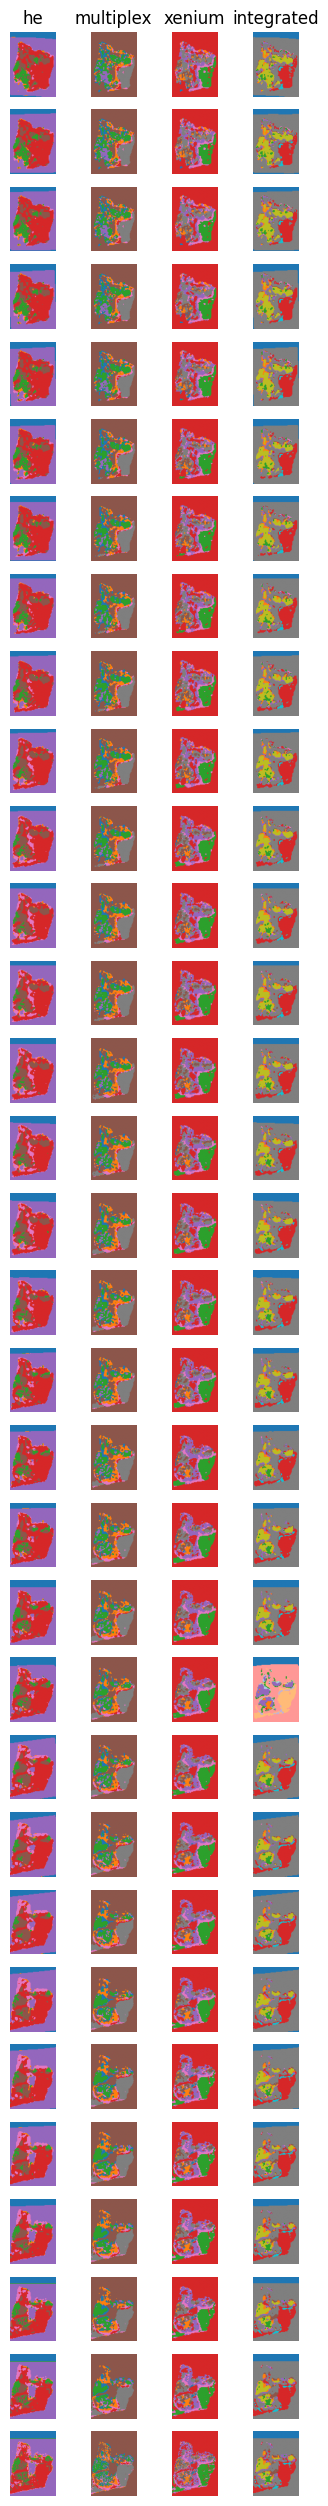

In [19]:
mushroom.display_volumes()

In [22]:
level = 1
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=level, resolution=2.)

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 16 clusters


In [23]:
level = 2
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=level, resolution=2.)

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:finished integration, found 19 clusters


In [24]:
dtype_to_df = mushroom.calculate_cluster_intensities(use_integrated=False)
dtype_to_df['xenium']

,ABCC11,ACAN,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,0.392106,0.336609,1.703704,1.131933,0.078345,2.797047,0.682843,-0.129902,1.320631,1.049563,...,0.653870,1.203120,0.921533,-0.046709,3.116768,0.440311,1.179109,0.314992,2.063617,0.432637
1,0.121097,0.930692,0.149236,0.316214,1.702784,0.634438,1.529748,1.785789,0.469306,1.433113,...,0.929822,0.257726,0.047163,1.926154,0.352034,2.193920,0.370196,1.308656,0.696337,1.219422
2,0.147716,0.792860,0.243007,0.404209,1.392690,0.808568,1.329192,1.459363,0.554468,1.311232,...,0.831085,0.319039,0.168389,1.570188,0.603383,1.875437,0.411202,1.120349,0.772462,1.079306
3,0.182289,1.694376,0.561664,0.671196,2.030243,2.225795,1.828953,1.851245,0.901772,2.561658,...,1.067338,0.638789,0.557283,1.651540,1.905523,2.620898,0.776010,1.089951,2.013895,1.518752
4,0.126205,1.283759,0.327467,0.505402,1.792408,1.480771,1.591715,1.631445,0.669893,1.993392,...,1.003994,0.402909,0.325417,1.658915,1.202557,2.231761,0.553143,1.071257,1.372694,1.230245
5,0.097842,2.132119,0.237027,0.432990,3.196073,1.600559,2.507436,3.001257,0.693053,3.048671,...,1.329226,0.343840,0.179331,2.904768,0.954875,3.671307,0.451347,1.882718,1.693618,2.106203
6,0.119940,1.290899,0.215887,0.437967,1.986251,1.142231,1.694624,1.930408,0.595175,1.936445,...,1.001174,0.341448,0.186832,1.960159,0.827534,2.452567,0.440893,1.256738,1.120443,1.345456
7,0.179528,0.708275,0.460905,0.597760,0.991591,1.266524,1.087501,0.957526,0.724706,1.257427,...,0.805556,0.505762,0.341086,1.123169,1.162963,1.517540,0.630251,0.803994,1.070153,0.867540
8,0.146259,0.883739,0.333176,0.495603,1.289109,1.169209,1.196361,1.190723,0.616627,1.442128,...,0.839728,0.384397,0.285304,1.299085,1.032465,1.727050,0.490126,0.838686,1.036478,0.908524
9,0.219749,0.170458,0.167543,0.235329,0.550760,0.090530,0.640589,0.891531,0.292337,0.503625,...,0.339455,0.135314,0.024838,0.686055,-0.004591,0.920588,0.148270,0.861744,0.143717,0.671818


In [25]:
dtype_to_df = mushroom.calculate_cluster_intensities(use_integrated=True)
dtype_to_df['xenium']

,ABCC11,ACAN,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,-0.159116,-0.234899,-0.321274,-0.274794,-0.457204,-0.568711,-0.455037,-0.438870,-0.328938,-0.477867,...,-0.442380,-0.208849,-0.176467,-0.549999,-0.524236,-0.649397,-0.259944,-0.467492,-0.462930,-0.388518
1,0.229660,0.612073,0.794240,0.672815,0.740056,1.736209,0.901252,0.575185,0.841634,1.178937,...,0.713393,0.645525,0.514181,0.680758,1.756924,1.112387,0.740027,0.531888,1.361884,0.630998
2,0.153866,0.410973,0.479322,0.479116,0.634183,1.106495,0.709075,0.495172,0.598032,0.821070,...,0.643245,0.432286,0.328515,0.724795,1.109175,0.956314,0.519138,0.462557,0.865147,0.481120
3,0.040705,0.173030,0.118045,0.174029,0.534410,0.364480,0.415641,0.379263,0.222097,0.348729,...,0.525217,0.138748,0.086543,0.761070,0.288687,0.687011,0.180527,0.328303,0.270659,0.260835
4,0.146294,0.365977,0.484515,0.440703,0.546108,1.080864,0.614011,0.393931,0.552352,0.734799,...,0.574760,0.412003,0.323682,0.607934,1.087476,0.808322,0.473249,0.386711,0.836999,0.411138
5,-0.008242,0.081849,-0.015280,0.064677,0.413592,0.100468,0.266634,0.260517,0.086740,0.163762,...,0.409363,0.043177,0.008946,0.641965,0.028033,0.504226,0.066877,0.209772,0.066867,0.141933
6,0.065536,0.271822,0.090507,0.192337,0.750650,0.292539,0.652912,0.730216,0.254653,0.526723,...,0.571426,0.137795,0.050416,0.986789,0.167687,0.997350,0.183555,0.591753,0.268923,0.489336
7,0.071698,0.210439,0.230505,0.269849,0.487035,0.589097,0.455362,0.326649,0.339921,0.442974,...,0.528127,0.230247,0.170504,0.664837,0.561305,0.686159,0.285355,0.313381,0.442323,0.273209
8,-0.114828,-0.162107,-0.236842,-0.188293,-0.224728,-0.395611,-0.274961,-0.256006,-0.224081,-0.321358,...,-0.203131,-0.147088,-0.128401,-0.221503,-0.385121,-0.345841,-0.179915,-0.282227,-0.329944,-0.253153
9,0.145435,0.873875,0.522765,0.493472,1.204000,1.415598,1.112364,1.033143,0.652563,1.417752,...,0.740292,0.474245,0.344613,1.101296,1.279102,1.519482,0.543527,0.724586,1.218856,0.862229


In [26]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1_2024-01-25_18_03_24_580462/outputs


In [27]:
# new = Mushroom.from_config(
#     os.path.join(out_dir, 'config.yaml'),
#     accelerator='cpu'
# )